In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [2]:
num_clusters = 6

In [3]:
# Collect statistics from images in a cluster first, then collect statistics for the entire cluster
def analyze_cluster_image_first(cluster_path):
    image_rgb_stats = []
    image_lab_stats = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue  # Skip this image if all pixels are black
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            # Calculate RGB and LAB statistics for this image
            img_rgb_stats = {
                'avg': np.mean(img_rgb_filtered, axis=0),
                'min': np.min(img_rgb_filtered, axis=0),
                'max': np.max(img_rgb_filtered, axis=0)
            }
            img_lab_stats = {
                'avg': np.mean(img_lab_filtered, axis=0),
                'min': np.min(img_lab_filtered, axis=0),
                'max': np.max(img_lab_filtered, axis=0)
            }
            
            image_rgb_stats.append(img_rgb_stats)
            image_lab_stats.append(img_lab_stats)
    
    if len(image_rgb_stats) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    # Step 2: Aggregate the image statistics to calculate cluster statistics
    avg_rgb_values = np.mean([img_stats['avg'] for img_stats in image_rgb_stats], axis=0)
    min_rgb_values = np.min([img_stats['min'] for img_stats in image_rgb_stats], axis=0)
    max_rgb_values = np.max([img_stats['max'] for img_stats in image_rgb_stats], axis=0)
    
    avg_lab_values = np.mean([img_stats['avg'] for img_stats in image_lab_stats], axis=0)
    min_lab_values = np.min([img_stats['min'] for img_stats in image_lab_stats], axis=0)
    max_lab_values = np.max([img_stats['max'] for img_stats in image_lab_stats], axis=0)
    
    return {
        'rgb': {
            'avg': avg_rgb_values,
            'min': min_rgb_values,
            'max': max_rgb_values
        },
        'lab': {
            'avg': avg_lab_values,
            'min': min_lab_values,
            'max': max_lab_values
        }
    }

In [4]:
# Collect average RGB/LAB values of all images in a cluster, then use those averages to calculate cluster statistics
def analyze_cluster_image_averages(cluster_path):
    image_rgb_avgs = []
    image_lab_avgs = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue  # Skip this image if all pixels are black
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            # Calculate average RGB and LAB values for this image
            img_rgb_avg = np.mean(img_rgb_filtered, axis=0)
            img_lab_avg = np.mean(img_lab_filtered, axis=0)
            
            image_rgb_avgs.append(img_rgb_avg)
            image_lab_avgs.append(img_lab_avg)
    
    if len(image_rgb_avgs) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    # Convert lists to numpy arrays for easier calculations
    image_rgb_avgs = np.array(image_rgb_avgs)
    image_lab_avgs = np.array(image_lab_avgs)
    
    return {
        'rgb': {
            'avg': np.mean(image_rgb_avgs, axis=0),
            'min': np.min(image_rgb_avgs, axis=0),
            'max': np.max(image_rgb_avgs, axis=0)
        },
        'lab': {
            'avg': np.mean(image_lab_avgs, axis=0),
            'min': np.min(image_lab_avgs, axis=0),
            'max': np.max(image_lab_avgs, axis=0)
        }
    }

# Utility Functions

In [5]:
def collect_statistics(clusters_root_path, analysis_type='all_pixels'):
    clusters_stats = []
    # Iterate over each cluster directory
    for cluster_name in os.listdir(clusters_root_path):
        cluster_path = os.path.join(clusters_root_path, cluster_name)
        if os.path.isdir(cluster_path):
            print(f"Analyzing cluster: {cluster_name}")
            if analysis_type == 'all_pixels':
                stats = analyze_cluster_image_first(cluster_path)
            elif analysis_type == 'image_averages':
                stats = analyze_cluster_image_averages(cluster_path)
            else:
                raise ValueError("Invalid analysis_type.")
            
            # Flatten the stats dictionary
            stats_flat = {
                'cluster_name': cluster_name,
                'rgb_avg_r': stats['rgb']['avg'][0],
                'rgb_avg_g': stats['rgb']['avg'][1],
                'rgb_avg_b': stats['rgb']['avg'][2],
                'rgb_min_r': stats['rgb']['min'][0],
                'rgb_min_g': stats['rgb']['min'][1],
                'rgb_min_b': stats['rgb']['min'][2],
                'rgb_max_r': stats['rgb']['max'][0],
                'rgb_max_g': stats['rgb']['max'][1],
                'rgb_max_b': stats['rgb']['max'][2],
                'lab_avg_l': stats['lab']['avg'][0],
                'lab_avg_a': stats['lab']['avg'][1],
                'lab_avg_b': stats['lab']['avg'][2],
                'lab_min_l': stats['lab']['min'][0],
                'lab_min_a': stats['lab']['min'][1],
                'lab_min_b': stats['lab']['min'][2],
                'lab_max_l': stats['lab']['max'][0],
                'lab_max_a': stats['lab']['max'][1],
                'lab_max_b': stats['lab']['max'][2],
            }
            clusters_stats.append(stats_flat)
    # Convert list of dictionaries to a pandas DataFrame
    df_stats = pd.DataFrame(clusters_stats)
    return df_stats

In [6]:
def save_statistics_to_csv(df_stats, csv_file_path):
    df_stats.to_csv(csv_file_path, index=False)
    
    
def visualize_cluster_stats(stats, cluster_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RGB visualization
    rgb_data = np.array([stats['rgb']['min'], stats['rgb']['avg'], stats['rgb']['max']])
    print("RGB Data before normalization:", rgb_data)
    rgb_data_normalized = rgb_data / 255.0  # Normalize to [0, 1]
    rgb_data_normalized = np.clip(rgb_data_normalized, 0, 1)  # Ensure values are within [0,1]
    ax1.imshow(rgb_data_normalized.reshape(1, -1, 3))
    ax1.set_title(f'{cluster_name} - RGB Values')
    ax1.set_yticks([])
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['Min', 'Avg', 'Max'])
    
    # LAB visualization
    lab_data = np.array([stats['lab']['min'], stats['lab']['avg'], stats['lab']['max']])
    print("LAB Data before conversion:", lab_data)
    lab_data_clipped = np.clip(lab_data, 0, 255)
    lab_data_uint8 = lab_data_clipped.astype(np.uint8).reshape(1, -1, 3)
    lab_data_bgr = cv2.cvtColor(lab_data_uint8, cv2.COLOR_LAB2BGR)
    lab_data_rgb = cv2.cvtColor(lab_data_bgr, cv2.COLOR_BGR2RGB)
    lab_data_rgb_normalized = lab_data_rgb / 255.0  # Normalize to [0, 1]
    lab_data_rgb_normalized = np.clip(lab_data_rgb_normalized, 0, 1)
    ax2.imshow(lab_data_rgb_normalized)
    ax2.set_title(f'{cluster_name} - LAB Values')
    ax2.set_yticks([])
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(['Min', 'Avg', 'Max'])
    
    plt.tight_layout()
    plt.show()


def visualize_clusters_average_colors(df_stats):
    # Number of clusters
    num_clusters = len(df_stats)
    
    # Get the average RGB values and cluster names
    avg_colors = df_stats[['rgb_avg_r', 'rgb_avg_g', 'rgb_avg_b']].values
    cluster_names = df_stats['cluster_name'].tolist()
    
    avg_colors_normalized = avg_colors / 255.0
    avg_colors_normalized = np.clip(avg_colors_normalized, 0, 1)
    
    cols = min(num_clusters, 5)
    rows = (num_clusters + cols - 1) // cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    # Flatten axes array for easy iteration if it's 2D
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if num_clusters == 1 else axes
    
    for i in range(num_clusters):
        color_patch = np.ones((10, 10, 3)) * avg_colors_normalized[i].reshape(1, 1, 3)
        axes[i].imshow(color_patch)
        axes[i].axis('off')
        axes[i].set_title(cluster_names[i], fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Cluster Statistics (All Pixels)

Analyzing cluster: cluster_0
Analyzing cluster: cluster_1
Analyzing cluster: cluster_2
Analyzing cluster: cluster_3
Analyzing cluster: cluster_4
Analyzing cluster: cluster_5
Statistics have been saved to clusters_statistics_all_pixels_coating_6.csv
RGB Data before normalization: [[ 10.           5.           6.        ]
 [173.56684236 136.61690684 140.02047964]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  5.         126.         105.        ]
 [153.69878472 142.69812951 131.68888138]
 [255.         167.         156.        ]]


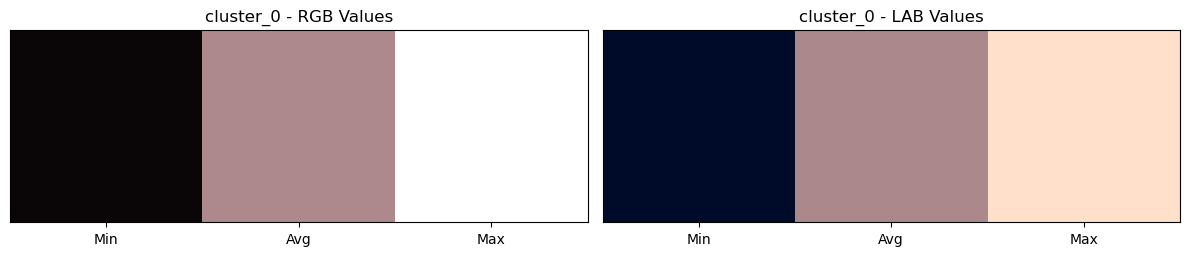

RGB Data before normalization: [[ 28.           0.           0.        ]
 [172.048526   129.25534668 117.91930237]
 [255.         247.         235.        ]]
LAB Data before conversion: [[  9.          96.         102.        ]
 [146.97470398 143.04413757 140.73330078]
 [249.         162.         167.        ]]


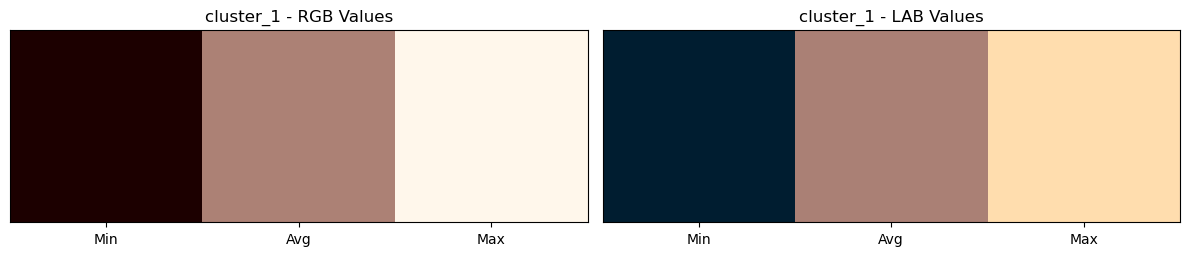

RGB Data before normalization: [[  3.           0.           0.        ]
 [172.00226475 156.23797756 151.71163419]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  1.         112.         120.        ]
 [166.76531734 133.09807903 132.53846505]
 [255.         156.         157.        ]]


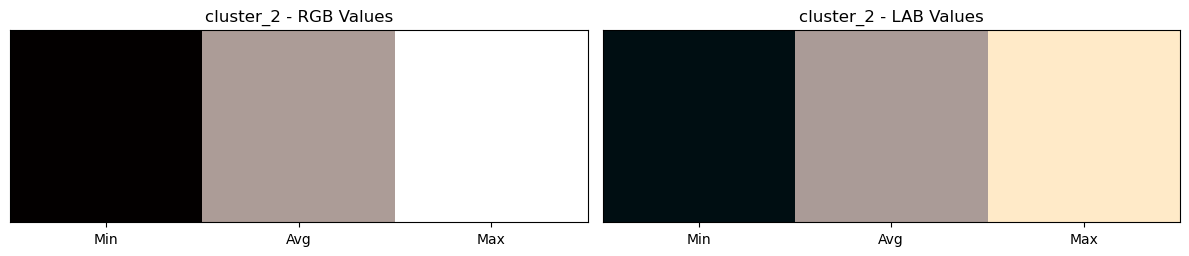

RGB Data before normalization: [[ 22.           0.           4.        ]
 [201.99789608 142.80598988 154.07746259]
 [255.         250.         255.        ]]
LAB Data before conversion: [[  7.         127.         110.        ]
 [166.56020849 152.12105874 131.20418593]
 [252.         176.         158.        ]]


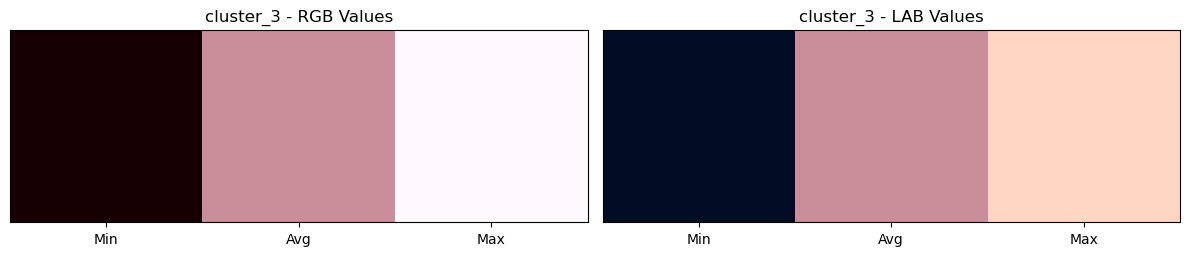

RGB Data before normalization: [[ 22.          11.           9.        ]
 [166.76896159 146.08359242 161.73138718]
 [255.         253.         255.        ]]
LAB Data before conversion: [[ 10.         121.          98.        ]
 [159.86803784 138.63731997 122.7042145 ]
 [254.         171.         144.        ]]


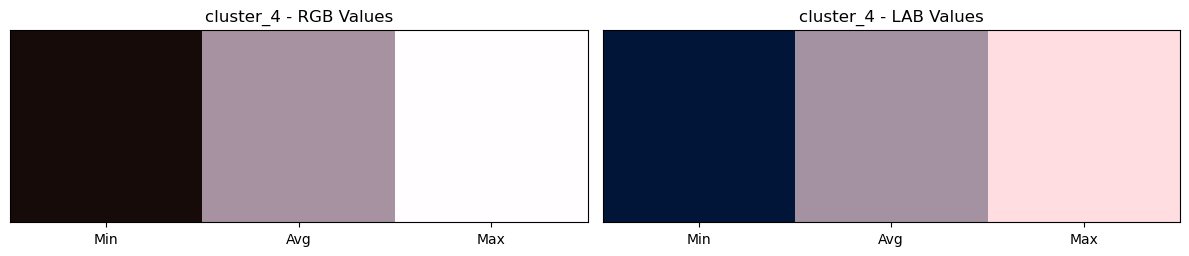

RGB Data before normalization: [[ 15.           0.           0.        ]
 [168.32524865 103.42391634  90.7229168 ]
 [255.         249.         232.        ]]
LAB Data before conversion: [[  2.         118.         125.        ]
 [128.33896156 152.77394835 146.50669233]
 [249.         187.         179.        ]]


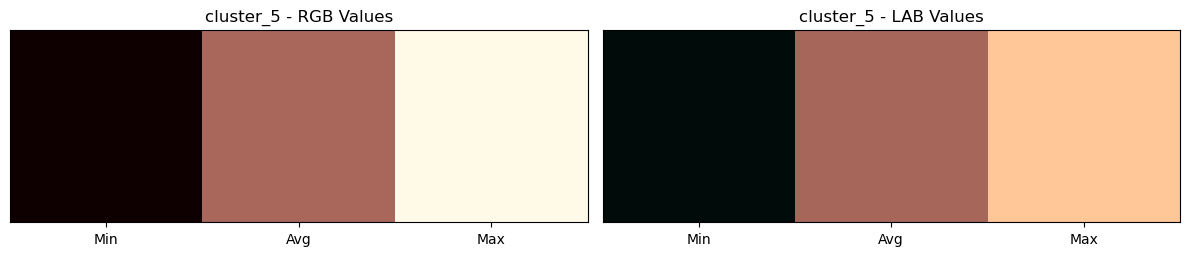

In [7]:
clusters_root_path = f"clusters/coating_no_oversaturated/{num_clusters}-clusters"
all_pixels_csv_file_path = f'clusters_statistics_all_pixels_coating_{num_clusters}.csv'

df_stats_all_pixels = collect_statistics(clusters_root_path)
save_statistics_to_csv(df_stats_all_pixels, all_pixels_csv_file_path)

print(f"Statistics have been saved to {all_pixels_csv_file_path}")

for index, row in df_stats_all_pixels.iterrows():
    stats = {
        'rgb': {
            'avg': np.array([row['rgb_avg_r'], row['rgb_avg_g'], row['rgb_avg_b']]),
            'min': np.array([row['rgb_min_r'], row['rgb_min_g'], row['rgb_min_b']]),
            'max': np.array([row['rgb_max_r'], row['rgb_max_g'], row['rgb_max_b']])
        },
        'lab': {
            'avg': np.array([row['lab_avg_l'], row['lab_avg_a'], row['lab_avg_b']]),
            'min': np.array([row['lab_min_l'], row['lab_min_a'], row['lab_min_b']]),
            'max': np.array([row['lab_max_l'], row['lab_max_a'], row['lab_max_b']])
        }
    }
    visualize_cluster_stats(stats, row['cluster_name'])

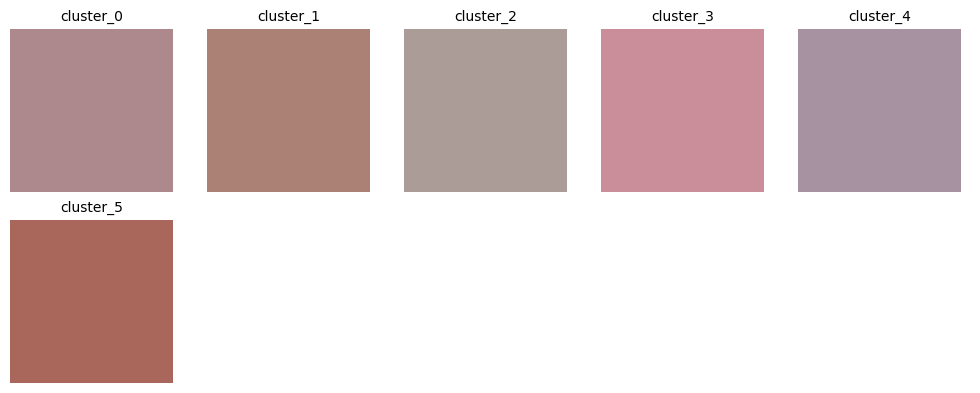

In [8]:
visualize_clusters_average_colors(df_stats_all_pixels)

# Cluster Statistics (Image Averages)

Analyzing cluster: cluster_0
Analyzing cluster: cluster_1
Analyzing cluster: cluster_2
Analyzing cluster: cluster_3
Analyzing cluster: cluster_4
Analyzing cluster: cluster_5
Statistics have been saved to clusters_statistics_image_averages_coating_6.csv
RGB Data before normalization: [[ 70.20532227  40.90698242  36.98339844]
 [173.56684236 136.61690684 140.02047964]
 [238.83886719 193.0559082  205.28833008]]
LAB Data before conversion: [[ 51.34179688 137.66992188 125.6262207 ]
 [153.69878472 142.69812951 131.68888138]
 [206.11743164 147.35571289 136.19604492]]


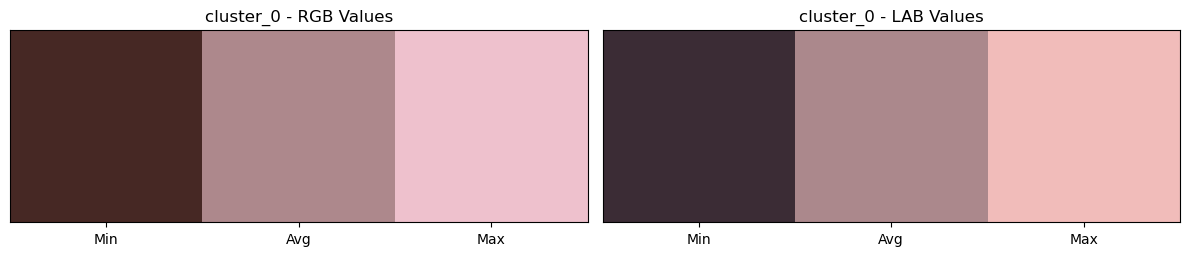

RGB Data before normalization: [[ 84.97021484  49.77709961  46.34887695]
 [172.048526   129.25534668 117.91930237]
 [249.84448242 200.12426758 192.0078125 ]]
LAB Data before conversion: [[ 67.46655273 134.26342773 136.16674805]
 [146.97470398 143.04413757 140.73330078]
 [214.11669922 149.52612305 152.82983398]]


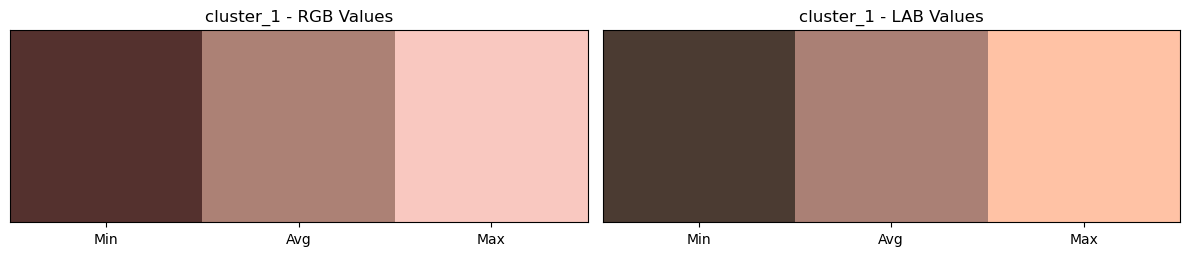

RGB Data before normalization: [[ 51.33935547  34.28686523  30.18017578]
 [172.00226475 156.23797756 151.71163419]
 [237.11743164 220.73754883 227.48779297]]
LAB Data before conversion: [[ 39.19921875 116.6887207  123.79101562]
 [166.76531734 133.09807903 132.53846505]
 [223.45288086 137.93798828 148.16308594]]


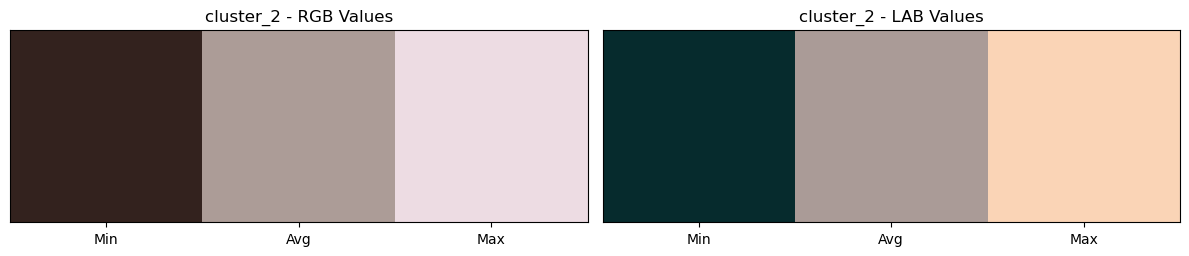

RGB Data before normalization: [[137.05224609  83.11621094  89.27880859]
 [201.99789608 142.80598988 154.07746259]
 [248.90576172 200.66235352 218.47387695]]
LAB Data before conversion: [[108.88037109 147.16894531 116.63110352]
 [166.56020849 152.12105874 131.20418593]
 [217.98974609 165.93383789 138.76049805]]


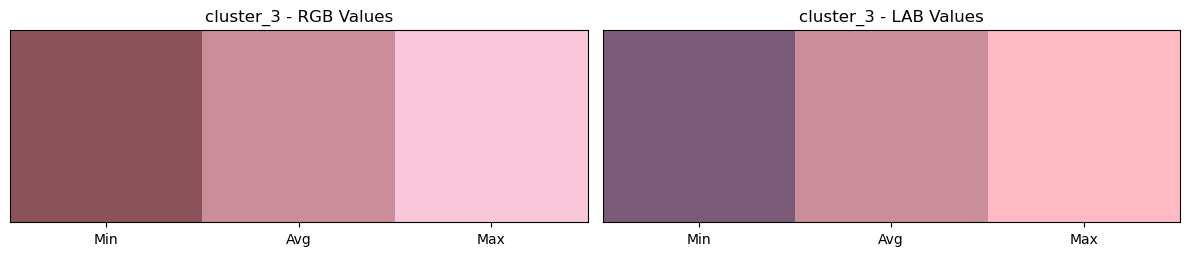

RGB Data before normalization: [[ 83.70288086  79.72485352  86.01928711]
 [166.76896159 146.08359242 161.73138718]
 [224.10693359 208.41625977 231.46777344]]
LAB Data before conversion: [[ 87.48974609 130.11669922 115.37329102]
 [159.86803784 138.63731997 122.7042145 ]
 [214.19995117 150.73925781 127.86206055]]


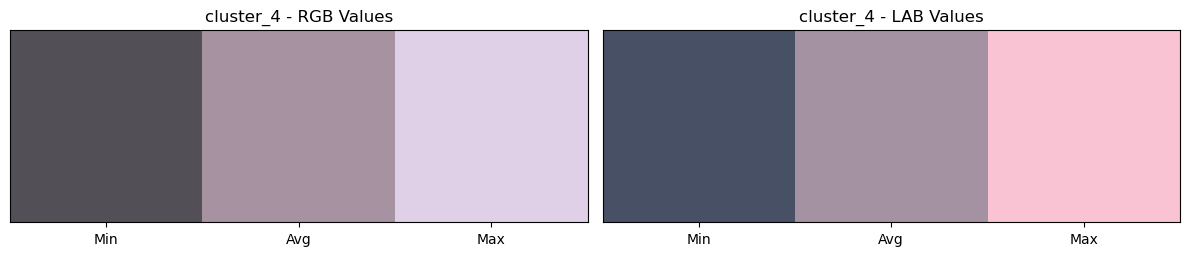

RGB Data before normalization: [[ 98.53027344  42.99609375  36.4387207 ]
 [168.32524865 103.42391634  90.7229168 ]
 [249.34790039 183.4453125  158.38989258]]
LAB Data before conversion: [[ 64.67944336 142.94165039 139.48095703]
 [128.33896156 152.77394835 146.50669233]
 [203.49365234 163.05004883 163.30566406]]


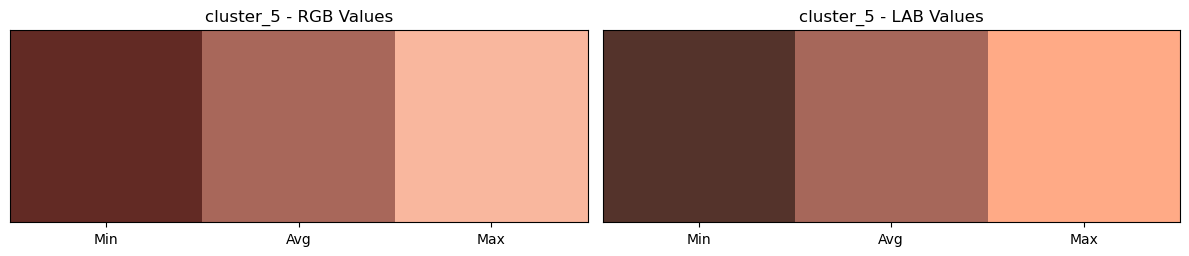

In [9]:
img_averages_csv_file_path = f'clusters_statistics_image_averages_coating_{num_clusters}.csv'
df_stats_avgs = collect_statistics(clusters_root_path, 'image_averages')
save_statistics_to_csv(df_stats_avgs, img_averages_csv_file_path)

print(f"Statistics have been saved to {img_averages_csv_file_path}")

for index, row in df_stats_avgs.iterrows():
    stats = {
        'rgb': {
            'avg': np.array([row['rgb_avg_r'], row['rgb_avg_g'], row['rgb_avg_b']]),
            'min': np.array([row['rgb_min_r'], row['rgb_min_g'], row['rgb_min_b']]),
            'max': np.array([row['rgb_max_r'], row['rgb_max_g'], row['rgb_max_b']])
        },
        'lab': {
            'avg': np.array([row['lab_avg_l'], row['lab_avg_a'], row['lab_avg_b']]),
            'min': np.array([row['lab_min_l'], row['lab_min_a'], row['lab_min_b']]),
            'max': np.array([row['lab_max_l'], row['lab_max_a'], row['lab_max_b']])
        }
    }
    visualize_cluster_stats(stats, row['cluster_name'])

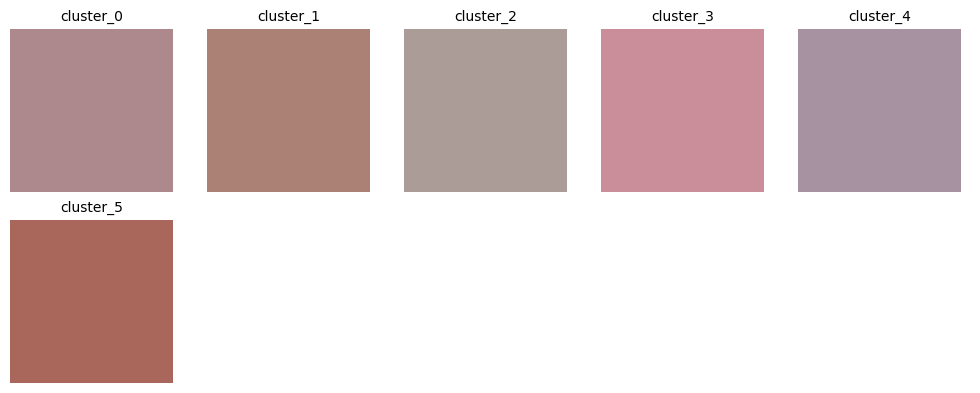

In [10]:
visualize_clusters_average_colors(df_stats_avgs)

# Furthest Images from Cluster Centroids

In [11]:
# Using image averages
def calculate_distances_to_centroids(clusters_root_path):
    distances_data = []
    
    # For each cluster directory
    for cluster_dir in Path(clusters_root_path).glob('*'):
        cluster_name = cluster_dir.name
        
        # Calculate cluster centroid from existing statistics
        centroid = df_stats_avgs[df_stats_avgs['cluster_name'] == cluster_name][['lab_avg_l', 'lab_avg_a', 'lab_avg_b']].values[0]
        
        # Process each image in cluster
        for img_path in cluster_dir.glob('*.png'):
            # Read and process image
            img = cv2.imread(str(img_path))
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            
            # Calculate average LAB values for image
            img_avg_lab = np.mean(img_lab.reshape(-1, 3), axis=0)
            
            # Calculate Euclidean distance
            distance = np.linalg.norm(img_avg_lab - centroid)
            
            distances_data.append({
                'image_name': img_path.name,
                'cluster': cluster_name,
                'centroid_distance': distance
            })
    
    return pd.DataFrame(distances_data)

In [12]:
distances_df = calculate_distances_to_centroids(clusters_root_path)
distances_df.to_csv(f'cluster_distances_coating_{num_clusters}.csv', index=False)

In [13]:
distances_df

,image_name,cluster,centroid_distance
0,test_00001.png,cluster_0,2.491794
1,test_00013.png,cluster_0,8.240515
2,test_00018.png,cluster_0,15.709551
3,test_00029.png,cluster_0,26.439091
4,test_00037.png,cluster_0,16.852408
...,...,...,...
1050,valid_00167.png,cluster_5,39.123523
1051,valid_00186.png,cluster_5,54.900424
1052,valid_00188.png,cluster_5,25.563399
1053,valid_00195.png,cluster_5,12.103602


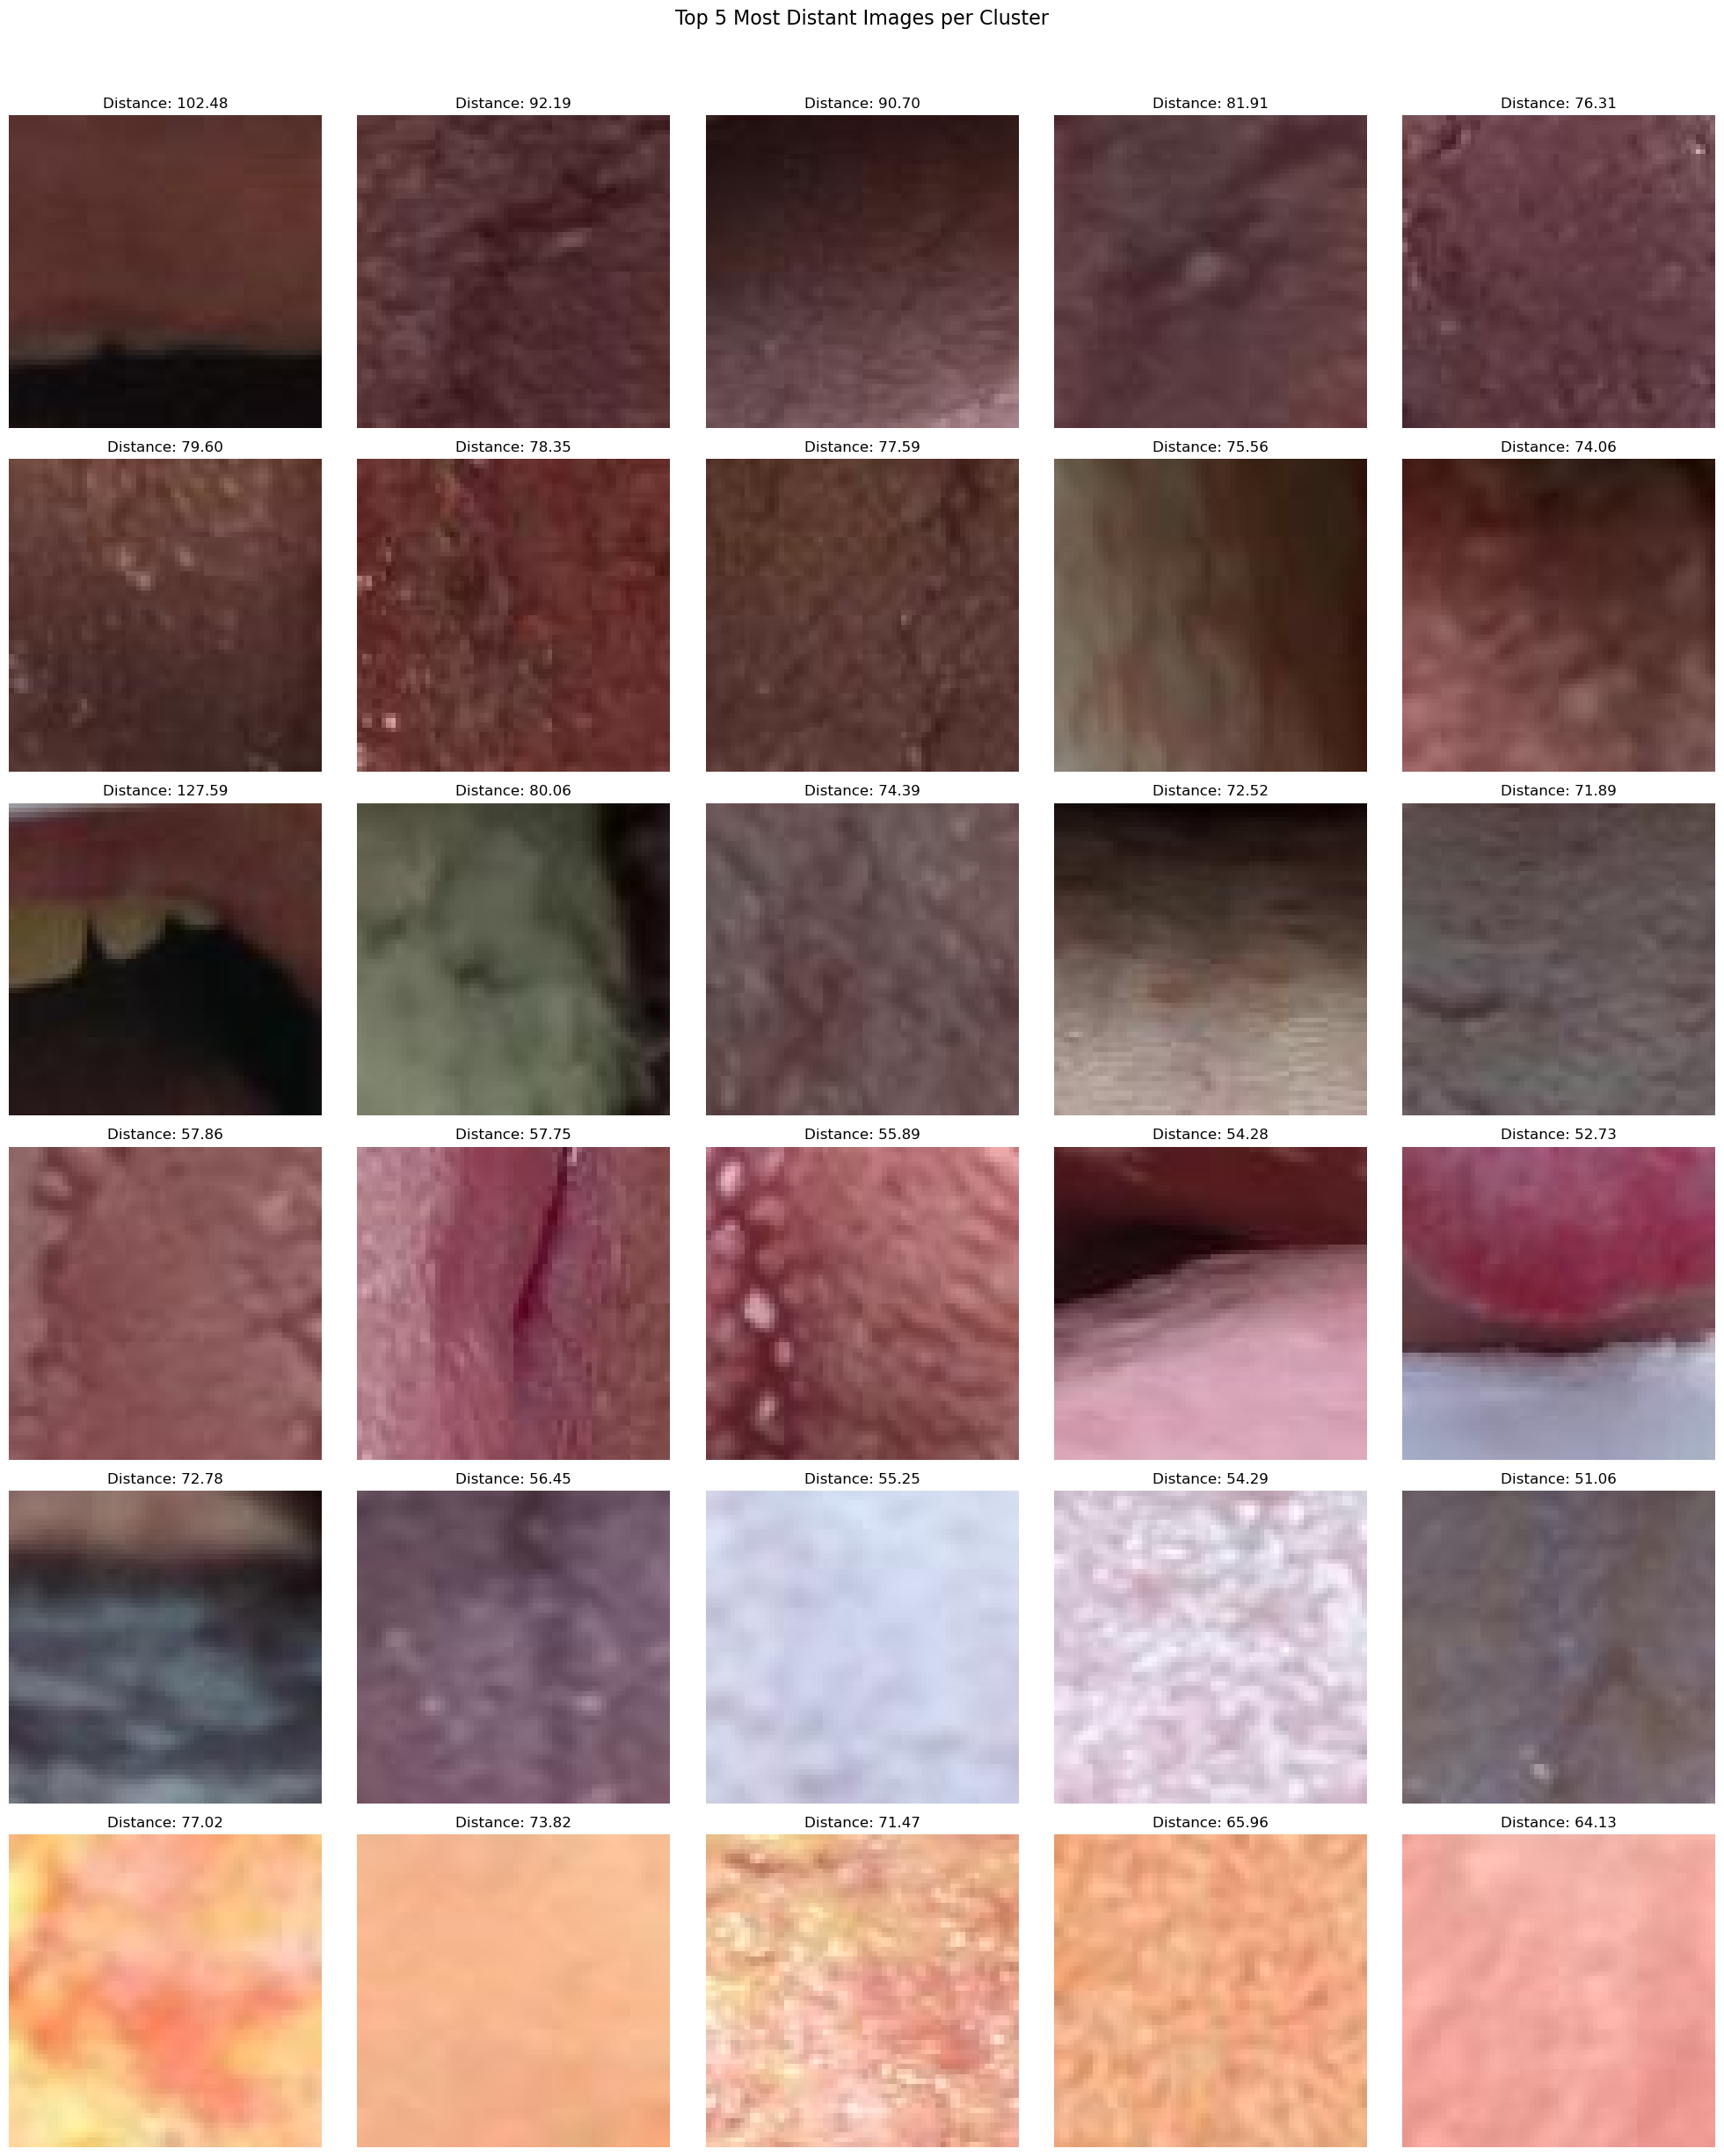

In [15]:
distances_df = pd.read_csv(f'cluster_distances_coating_{num_clusters}.csv')

# Get unique clusters
clusters = distances_df['cluster'].unique()

# Create a figure with subplots for each cluster
fig, axes = plt.subplots(len(clusters), 5, figsize=(20, 4*len(clusters)))

# For each cluster
for cluster_idx, cluster in enumerate(clusters):
    # Get cluster-specific data
    cluster_data = distances_df[distances_df['cluster'] == cluster]
    
    # Get top 5 distant images for this cluster
    top_5_cluster = cluster_data.nlargest(5, 'centroid_distance')
    
    # Plot each image
    for img_idx, (_, row) in enumerate(top_5_cluster.iterrows()):
        img = plt.imread(f'clusters/coating_no_oversaturated/{num_clusters}-clusters/' + row['cluster'] + '/' + row['image_name'])
        axes[cluster_idx, img_idx].imshow(img)
        axes[cluster_idx, img_idx].set_title(f"Distance: {row['centroid_distance']:.2f}")
        axes[cluster_idx, img_idx].axis('off')
    
plt.suptitle('Top 5 Most Distant Images per Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()